## Общая информация

Подготовка прототипа модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.
Модель предсказывает коэффициент восстановления золота из золотосодержащей руды. Для этого используются данные с параметрами добычи и очистки.
Модель помогает оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

## Загрузка и подготовка данных¶

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import math

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve 
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import svm, datasets
from joblib import dump
pd.options.mode.chained_assignment = None


Откроем файлы и сделаем колонку 'date' индексом.

In [2]:
try:
    train = pd.read_csv('/datasets/gold_recovery_train_new.csv', index_col='date')
    test = pd.read_csv('/datasets/gold_recovery_test_new.csv', index_col='date')
    full = pd.read_csv('//datasets/gold_recovery_full_new.csv', index_col='date')
    
except:
    train = pd.read_csv('/content/gold_recovery_train_new.csv', index_col='date')
    test = pd.read_csv('/content/gold_recovery_test_new.csv', index_col='date')
    full = pd.read_csv('/content/gold_recovery_full_new.csv', index_col='date')  
    
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

Данные находятся в трёх файлах:

    gold_recovery_train_new.csv — обучающая выборка;
    gold_recovery_test_new.csv — тестовая выборка;
    gold_recovery_full_new.csv — исходные данные.

Технологический процесс

    Rougher feed — исходное сырье
    Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
        Xanthate **— ксантогенат (промотер, или активатор флотации);
        Sulphate — сульфат (на данном производстве сульфид натрия);
        Depressant — депрессант (силикат натрия).
    Rougher process (англ. «грубый процесс») — флотация
    Rougher tails — отвальные хвосты
    Float banks — флотационная установка
    Cleaner process — очистка
    Rougher Au — черновой концентрат золота
    Final Au — финальный концентрат золота

Параметры этапов

    air amount — объём воздуха
    fluid levels — уровень жидкости
    feed size — размер гранул сырья
    feed rate — скорость подачи

Наименование признаков:

[этап].[тип_параметра].[название_параметра]

Возможные значения для блока [этап]:

    rougher — флотация
    primary_cleaner — первичная очистка
    secondary_cleaner — вторичная очистка
    final — финальные характеристики

Возможные значения для блока [тип_параметра]:

    input — параметры сырья
    output — параметры продукта
    state — параметры, характеризующие текущее состояние этапа
    calculation — расчётные характеристики

In [3]:
train.head()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.

In [4]:
test.head()

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,1399.001695,-499.485144,13.128569,5.636710,489.793655,62.710452,42.022440,12.084103,16.922877,6.153479,16.867518,6.150709,1001.849317,-350.301265,1249.738612,-399.107531,1249.750520,-399.396730,1198.287855,-399.488594,999.472250,-399.530962,949.566189,-398.180807,24.938200,-500.490963,14.947607,-500.013837,20.018166,-450.395995,13.987058,-449.831513,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,1399.508091,-500.416324,13.036280,5.526065,490.104534,61.961163,41.187903,11.918977,17.002532,5.999043,16.996063,6.002315,998.690785,-350.425704,1248.395457,-399.946025,1249.514451,-399.630810,1200.506459,-399.942434,1000.002114,-399.491528,950.200009,-405.787514,24.923466,-499.813963,14.930873,-500.764452,19.988503,-450.114024,14.092981,-450.059163,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,1399.497088,-499.715479,13.138412,5.426561,489.617969,66.903807,42.546294,12.091332,16.992520,5.850632,16.982096,5.853594,998.516720,-349.783538,1247.440748,-400.264330,1248.207204,-401.074405,1199.770026,-400.790582,999.925519,-399.236999,950.320481,-400.864340,24.908732,-500.304035,14.996511,-500.993821,20.039689,-450.263164,14.077881,-449.660997,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,1401.065165,-501.038738,12.400507,5.114758,476.618130,59.865919,41.060195,12.181597,16.532144,5.801935,16.515277,5.803657,1000.276604,-350.172597,1251.322675,-398.655289

In [5]:
full.head()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6506 entries, 2016-01-15 00:00:00 to 2017-03-31 05:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         6505 non-null   float64
 1   final.output.concentrate_pb                         6505 non-null   float64
 2   final.output.concentrate_sol                        6295 non-null   float64
 3   final.output.concentrate_au                         6506 non-null   float64
 4   final.output.recovery                               6506 non-null   float64
 5   final.output.tail_ag                                6506 non-null   float64
 6   final.output.tail_pb                                6499 non-null   float64
 7   final.output.tail_sol                               6505 non-null   float64
 8   final.output.tail_au                              

In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5290 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               5286 non-null   float64
 1   primary_cleaner.input.depressant            5285 non-null   float64
 2   primary_cleaner.input.feed_size             5290 non-null   float64
 3   primary_cleaner.input.xanthate              5286 non-null   float64
 4   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 5   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 6   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 8   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_level    5290 non-null

In [8]:
full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7135 entries, 2016-01-15 00:00:00 to 2016-12-24 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         7134 non-null   float64
 1   final.output.concentrate_pb                         7134 non-null   float64
 2   final.output.concentrate_sol                        6924 non-null   float64
 3   final.output.concentrate_au                         7135 non-null   float64
 4   final.output.recovery                               7135 non-null   float64
 5   final.output.tail_ag                                7135 non-null   float64
 6   final.output.tail_pb                                7128 non-null   float64
 7   final.output.tail_sol                               7134 non-null   float64
 8   final.output.tail_au                              

In [9]:
train.describe()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,6505.000000,6505.000000,6295.000000,6506.000000,6506.000000,6506.000000,6499.000000,6505.000000,6506.000000,6499.000000,6494.000000,6506.000000,6475.000000,6506.000000,6450.000000,6382.000000,6506.000000,6505.000000,6497.000000,6496.000000,6506.000000,6502.000000,6505.000000,6502.000000,6505.000000,6504.000000,6505.000000,6503.000000,6505.000000,6.505000e+03,6505.000000,6505.000000,6506.000000,6506.000000,6495.000000,6505.000000,6368.000000,6463.000000,6506.000000,6502.000000,6505.000000,6501.000000,6217.000000,6506.000000,6506.000000,6500.000000,6506.000000,6506.000000,6505.000000,6506.000000,6506.000000,6506.000000,6505.000000,6505.000000,6505.000000,6505.000000,6505.000000,6505.000000,6506.000000,6506.000000,6506.000000,6506.000000,6506.000000,6506.000000,6505.000000,6500.000000,6484.000000,6506.000000,6493.000000,6504.000000,6496.000000,6504.000000,6501.000000,6504.000000,6504.000000,6504.000000,6504.000000,6504.000000,6504.000000,6504.000000,6504.000000,6504.000000,6504.000000,6504.000000,6504.000000,6504.000000
mean,5.523880,9.899115,10.067424,43.36

In [10]:
test.describe()

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,5286.000000,5285.000000,5290.000000,5286.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5290.000000,5290.000000,5287.000000,5289.000000,5269.000000,5290.000000,5285.000000,5290.000000,5282.000000,5265.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5287.000000,5290.000000,5288.000000,5290.000000,5281.000000,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000
mean,174.839652,8.683596,7.266339,1.383803,1.539494e+03,-497.665883,1.545174e+03,-500.273098,1.527272e+03,-498.330680,1.544844e+03,-500.199527,9.371940,3.798082,489.800620,55.951097,37.716648,9.334682,13.855759,6.467745,13.922328,6.512103,1053.400166,-395.732530,1318.926879,-475.241428,1301.595477,-474.836671,1214.847960,-475.682272,1056.648995,-469.029688,997.949719,-470.482465,26.312630,-502.750897,21.949119,-501.987097,25.402926,-507.490314,2.098211e+01,-506.627916,1.632007e+01,-505.144570,1.373544e+01,-463.349858,12.804186,-501.329122,9.881145,-495.663398,17.304935,-501.793193
std,43.027080,3.072050,0.610219,0.643474,1.167979e+02,19.952431,1.222246e+02,32.968307,1.225380e+02,21.964876,1.247731e+02,31.045257,1.926264,0.954859,108.036326,19.081758,5.491415,1.619521,3.350852,1.065114,3.223769,0.886989,121.139309,91.085505,156.450366,45.649466,171.269667,45.859866,185.763319,47.844967,131.542839,59.325990,128.218869,60.759318,3.429852,28.756505,4.354961,34.582722,6.526457,47.620908,6.736179e+00,44.528673,3.493583e+00,31.427337,3.430484e+00,86.189107,3.026591,17.951495,2.868205,34.535007,4.536544,39.044215
min,2.566156,0.003839,5.650000,0.004984,5.445860e-32,-795.316337,6.647490e-32,-799.997015,4.033736e-32,-799.960571,4.039220e-32,-799.794250,0.568441,0.273677,0.002986,0.046369,1.393488,0.568632,0.001147,0.000568,0.000077,0.006985,-0.042069,-657.949759,-0.721806,-650.245277,-0.056636,-647.544439,-0.992219,-648.390665,-1.982295,-649.267537,-2.593390,-649.949283,0.20

In [11]:
full.describe()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,7134.000000,7134.000000,6924.000000,7135.000000,7135.000000,7135.000000,7128.000000,7134.000000,7135.000000,7130.000000,7124.000000,7135.000000,7126.000000,7135.000000,7078.000000,7018.000000,7135.000000,7134.000000,7126.000000,7125.000000,7135.000000,7134.000000,7134.000000,7134.000000,7134.000000,7134.000000,7134.000000,7133.000000,7134.000000,7134.000000,7134.000000,7134.000000,7135.000000,7135.000000,7124.000000,7134.000000,6999.000000,7094.000000,7135.000000,7129.000000,7134.000000,7129.000000,7121.000000,7134.000000,7134.000000,7128.000000,7134.000000,7134.000000,7134.000000,7134.000000,7134.000000,7134.000000,7133.000000,7133.000000,7133.000000,7133.000000,7133.000000,7133.000000,7134.000000,7134.000000,7134.000000,7134.000000,7134.000000,7134.000000,7134.000000,7129.000000,7115.000000,7134.000000,7133.000000,7133.000000,7.130000e+03,7133.000000,7123.000000,7133.000000,7.133000e+03,7133.000000,7133.000000,7133.000000,7133.000000,7133.000000,7133.000000,7133.000000,7133.000000,7133.000000,7133.000000,7133.000000
mean,5.467858,9.656595,10.039276,43.6

In [12]:
train.corr()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
final.output.concentrate_ag,1.000000,0.090650,0.301450,-0.096231,0.160270,0.245220,0.028938,-0.038060,0.138038,0.003125,-0.018036,-0.089462,0.132743,0.585184,0.042872,0.260912,-0.303045,0.030705,-0.051911,0.049231,0.098184,0.229830,0.056468,0.217753,0.050058,0.189477,0.040751,0.166148,0.053971,-0.018894,-0.005263,-0.029026,0.087195,0.331095,0.052602,-0.124670,0.013148,0.033889,0.163263,0.007092,0.098513,-0.040352,0.109049,0.311799,-0.004328,-0.048992,-0.057073,0.135590,0.027776,-0.132618,0.013337,-0.042164,0.089756,0.037701,0.078867,0.141458,0.093411,0.160609,0.073812,0.159837,0.072215,0.178657,0.074360,0.175057,0.008332,-0.105232,-0.020321,0.107990,0.060869,0.077840,0.019779,0.074658,0.058124,0.159206,-0.009616,0.181943,0.203276,0.172614,0.099983,0.217484,0.166297,0.226563,0.154387,0.188429,0.193413,0.125150
final.output.concentrate_pb,0.090650,1.000000,0.016871,0.328440,0.137495,0.130629,0.142252,0.149843,0.130285,0.170236,0.191342,-0.025150,0.057879,0.060710,0.259782,0.105802,-0.050992,0.091003,0.156681,-0.002169,-0.128435,0.028050,0.152252,0.041337,0.145416

In [13]:
train.corr()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
final.output.concentrate_ag,1.000000,0.090650,0.301450,-0.096231,0.160270,0.245220,0.028938,-0.038060,0.138038,0.003125,-0.018036,-0.089462,0.132743,0.585184,0.042872,0.260912,-0.303045,0.030705,-0.051911,0.049231,0.098184,0.229830,0.056468,0.217753,0.050058,0.189477,0.040751,0.166148,0.053971,-0.018894,-0.005263,-0.029026,0.087195,0.331095,0.052602,-0.124670,0.013148,0.033889,0.163263,0.007092,0.098513,-0.040352,0.109049,0.311799,-0.004328,-0.048992,-0.057073,0.135590,0.027776,-0.132618,0.013337,-0.042164,0.089756,0.037701,0.078867,0.141458,0.093411,0.160609,0.073812,0.159837,0.072215,0.178657,0.074360,0.175057,0.008332,-0.105232,-0.020321,0.107990,0.060869,0.077840,0.019779,0.074658,0.058124,0.159206,-0.009616,0.181943,0.203276,0.172614,0.099983,0.217484,0.166297,0.226563,0.154387,0.188429,0.193413,0.125150
final.output.concentrate_pb,0.090650,1.000000,0.016871,0.328440,0.137495,0.130629,0.142252,0.149843,0.130285,0.170236,0.191342,-0.025150,0.057879,0.060710,0.259782,0.105802,-0.050992,0.091003,0.156681,-0.002169,-0.128435,0.028050,0.152252,0.041337,0.145416

In [14]:
full.corr()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
final.output.concentrate_ag,1.000000,0.081801,0.307440,-0.184575,0.142955,0.284033,-0.003019,-0.009165,0.124156,0.029619,-0.020361,-0.024365,0.117660,0.653558,0.037976,0.327647,-0.329316,0.058779,-0.052645,0.087657,0.100150,0.212552,0.050097,0.209404,0.041690,0.190464,0.026809,0.163515,0.039081,0.000951,-0.032902,-0.030605,0.102066,0.360671,0.064996,-0.122355,-0.004987,0.084710,0.175574,-0.051389,0.112991,-0.047205,0.125282,0.358792,0.046809,-0.021627,-0.012366,0.191651,-0.019429,-0.138115,-0.010295,-0.062731,-0.062901,-0.144057,0.083315,0.156000,0.115389,0.177593,0.100877,0.176185,0.064521,0.150849,0.048015,0.145032,0.035062,-0.157545,-0.019473,0.159535,0.043737,0.118725,-0.000612,0.128226,0.020082,0.146165,-0.011264,0.162196,0.184331,0.149534,0.074093,0.222729,0.118637,0.231321,0.082581,0.178803,0.159580,0.141627
final.output.concentrate_pb,0.081801,1.000000,-0.152507,0.233753,0.054629,0.074166,-0.023527,0.244274,0.017554,0.023151,0.245237,-0.010299,-0.020337,0.054047,0.169495,0.111998,0.070901,0.077450,0.119430,-0.081527,-0.135364,0.099824,0.252530,0.085069,

In [15]:
train.duplicated().sum()

0

In [16]:
test.duplicated().sum()

0

In [17]:
full.duplicated().sum()

0

Явных дубликатов нет.

## Расчёт эффективности обогащения. Расчет MAE между расчётами и значением признака



Эффективность обогащения рассчитывается по формуле:

recovery = (c * (f - t)) / (f * (c - t)) * 100,

где 

    C — доля золота в концентрате после флотации/очистки (rougher.output.concentrate_au);
    F — доля золота в сырье/концентрате до флотации/очистки (rougher.input.feed_au);
    T — доля золота в отвальных хвостах после флотации/очистки (rougher.output.tail_au).

In [18]:
def recovery (df, c, f, t):
  c = df[c]
  f = df[f]
  t = df[t]
  rec = (c * (f - t)) / (f * (c - t)) * 100
  return rec

In [19]:
recovery = recovery(train, 'rougher.output.concentrate_au', 'rougher.input.feed_au', 'rougher.output.tail_au')

In [20]:
recovery.head()

date
2016-01-15 00:00:00    87.107763
2016-01-15 01:00:00    86.843261
2016-01-15 02:00:00    86.842308
2016-01-15 03:00:00    87.226430
2016-01-15 04:00:00    86.688794
dtype: float64

In [21]:
display('Расчет MAE:', mean_absolute_error(train['rougher.output.recovery'], recovery))

'Расчет MAE:'

9.756583968510383e-15

MAE очень маленькое, что позволяет принять признаки в train['rougher.output.recovery'] как верные.

## Анализ признаков, недоступных в тестовой выборке

In [22]:
set(train.columns) - set(test.columns)

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

В тестовой выборке нет характеристик по получаемым параметрам продуктов (целевые признаки в том числе: rougher.output.recovery и final.output.recovery), и расчетным характеристикам продукта (calculation).

В задании об этом шла речь: "Некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей. Также в тестовом наборе нет целевых признаков."


## Предобработка данных

Добавим целевые признаки в таблицы train и test. и Из таблицы train удалим все лишние колонки которых нет в таблице test.

In [23]:
full_test = full[['rougher.output.recovery', 'final.output.recovery']]


In [24]:
test = test.merge(full_test, how='left', left_index=True, right_index=True) 
test.head(2)

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher.output.recovery,final.output.recovery
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-09-01 00:59:59,210.800909,14.993118,8.08,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,1399.001695,-499.485144,13.128569,5.636710,489.793655,62.710452,42.022440,12.084103,16.922877,6.153479,16.867518,6.150709,1001.849317,-350.301265,1249.738612,-399.107531,1249.750520,-399.39673,1198.287855,-399.488594,999.472250,-399.530962,949.566189,-398.180807,24.938200,-500.490963,14.947607,-500.013837,20.018166,-450.395995,13.987058,-449.831513,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414,89.993421,70.273583
2016-09-01 01:59:59,215.392455,14.987471,8.08,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,1399.508091,-500.416324,13.036280,5.526065,490.104534,61.961163,41.187903,11.918977,17.002532,5.999043,16.996063,6.002315,998.690785,-350.425704,1248.395457,-399.946025,1249.514451,-399.63081,1200.506459,-399.942434,1000.002114,-399.491528,950.200009,-405.787514,24.923466,-499.813963,14.930873,-500.764452,19.988503,-450.114024,14.092981,-450.059163,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438,88.089657,68.910432


In [25]:
train = train[test.columns]

Изучим пропуски:

In [26]:
train.isna().sum()

primary_cleaner.input.sulfate                   7
primary_cleaner.input.depressant               12
primary_cleaner.input.feed_size                 0
primary_cleaner.input.xanthate                 31
primary_cleaner.state.floatbank8_a_air          4
primary_cleaner.state.floatbank8_a_level        1
primary_cleaner.state.floatbank8_b_air          4
primary_cleaner.state.floatbank8_b_level        1
primary_cleaner.state.floatbank8_c_air          2
primary_cleaner.state.floatbank8_c_level        1
primary_cleaner.state.floatbank8_d_air          3
primary_cleaner.state.floatbank8_d_level        1
rougher.input.feed_ag                           0
rougher.input.feed_pb                          11
rougher.input.feed_rate                         1
rougher.input.feed_size                       138
rougher.input.feed_sol                         43
rougher.input.feed_au                           0
rougher.input.floatbank10_sulfate               4
rougher.input.floatbank10_xanthate              1


In [27]:
test.isna().sum()

primary_cleaner.input.sulfate                    4
primary_cleaner.input.depressant                 5
primary_cleaner.input.feed_size                  0
primary_cleaner.input.xanthate                   4
primary_cleaner.state.floatbank8_a_air           0
primary_cleaner.state.floatbank8_a_level         0
primary_cleaner.state.floatbank8_b_air           0
primary_cleaner.state.floatbank8_b_level         0
primary_cleaner.state.floatbank8_c_air           0
primary_cleaner.state.floatbank8_c_level         0
primary_cleaner.state.floatbank8_d_air           0
primary_cleaner.state.floatbank8_d_level         0
rougher.input.feed_ag                            0
rougher.input.feed_pb                            0
rougher.input.feed_rate                          3
rougher.input.feed_size                          1
rougher.input.feed_sol                          21
rougher.input.feed_au                            0
rougher.input.floatbank10_sulfate                5
rougher.input.floatbank10_xanth

In [28]:
full.isna().sum()

final.output.concentrate_ag                             1
final.output.concentrate_pb                             1
final.output.concentrate_sol                          211
final.output.concentrate_au                             0
final.output.recovery                                   0
final.output.tail_ag                                    0
final.output.tail_pb                                    7
final.output.tail_sol                                   1
final.output.tail_au                                    0
primary_cleaner.input.sulfate                           5
primary_cleaner.input.depressant                       11
primary_cleaner.input.feed_size                         0
primary_cleaner.input.xanthate                          9
primary_cleaner.output.concentrate_ag                   0
primary_cleaner.output.concentrate_pb                  57
primary_cleaner.output.concentrate_sol                117
primary_cleaner.output.concentrate_au                   0
primary_cleane

In [29]:
train.isna().mean()


primary_cleaner.input.sulfate                 0.001076
primary_cleaner.input.depressant              0.001844
primary_cleaner.input.feed_size               0.000000
primary_cleaner.input.xanthate                0.004765
primary_cleaner.state.floatbank8_a_air        0.000615
primary_cleaner.state.floatbank8_a_level      0.000154
primary_cleaner.state.floatbank8_b_air        0.000615
primary_cleaner.state.floatbank8_b_level      0.000154
primary_cleaner.state.floatbank8_c_air        0.000307
primary_cleaner.state.floatbank8_c_level      0.000154
primary_cleaner.state.floatbank8_d_air        0.000461
primary_cleaner.state.floatbank8_d_level      0.000154
rougher.input.feed_ag                         0.000000
rougher.input.feed_pb                         0.001691
rougher.input.feed_rate                       0.000154
rougher.input.feed_size                       0.021211
rougher.input.feed_sol                        0.006609
rougher.input.feed_au                         0.000000
rougher.in

In [30]:
test.isna().mean()

primary_cleaner.input.sulfate                 0.000756
primary_cleaner.input.depressant              0.000945
primary_cleaner.input.feed_size               0.000000
primary_cleaner.input.xanthate                0.000756
primary_cleaner.state.floatbank8_a_air        0.000000
primary_cleaner.state.floatbank8_a_level      0.000000
primary_cleaner.state.floatbank8_b_air        0.000000
primary_cleaner.state.floatbank8_b_level      0.000000
primary_cleaner.state.floatbank8_c_air        0.000000
primary_cleaner.state.floatbank8_c_level      0.000000
primary_cleaner.state.floatbank8_d_air        0.000000
primary_cleaner.state.floatbank8_d_level      0.000000
rougher.input.feed_ag                         0.000000
rougher.input.feed_pb                         0.000000
rougher.input.feed_rate                       0.000567
rougher.input.feed_size                       0.000189
rougher.input.feed_sol                        0.003970
rougher.input.feed_au                         0.000000
rougher.in

Заполним пропуски близлежащими значениями:

In [31]:
train = train.fillna(method='ffill')

In [32]:
test = test.fillna(method='ffill')

In [33]:
#train = train.fillna(method='bfill')

In [34]:
#test = test.fillna(method='bfill')

In [35]:
train.isna().mean()

primary_cleaner.input.sulfate                 0.0
primary_cleaner.input.depressant              0.0
primary_cleaner.input.feed_size               0.0
primary_cleaner.input.xanthate                0.0
primary_cleaner.state.floatbank8_a_air        0.0
primary_cleaner.state.floatbank8_a_level      0.0
primary_cleaner.state.floatbank8_b_air        0.0
primary_cleaner.state.floatbank8_b_level      0.0
primary_cleaner.state.floatbank8_c_air        0.0
primary_cleaner.state.floatbank8_c_level      0.0
primary_cleaner.state.floatbank8_d_air        0.0
primary_cleaner.state.floatbank8_d_level      0.0
rougher.input.feed_ag                         0.0
rougher.input.feed_pb                         0.0
rougher.input.feed_rate                       0.0
rougher.input.feed_size                       0.0
rougher.input.feed_sol                        0.0
rougher.input.feed_au                         0.0
rougher.input.floatbank10_sulfate             0.0
rougher.input.floatbank10_xanthate            0.0


In [36]:
test.isna().mean()

primary_cleaner.input.sulfate                 0.0
primary_cleaner.input.depressant              0.0
primary_cleaner.input.feed_size               0.0
primary_cleaner.input.xanthate                0.0
primary_cleaner.state.floatbank8_a_air        0.0
primary_cleaner.state.floatbank8_a_level      0.0
primary_cleaner.state.floatbank8_b_air        0.0
primary_cleaner.state.floatbank8_b_level      0.0
primary_cleaner.state.floatbank8_c_air        0.0
primary_cleaner.state.floatbank8_c_level      0.0
primary_cleaner.state.floatbank8_d_air        0.0
primary_cleaner.state.floatbank8_d_level      0.0
rougher.input.feed_ag                         0.0
rougher.input.feed_pb                         0.0
rougher.input.feed_rate                       0.0
rougher.input.feed_size                       0.0
rougher.input.feed_sol                        0.0
rougher.input.feed_au                         0.0
rougher.input.floatbank10_sulfate             0.0
rougher.input.floatbank10_xanthate            0.0


In [37]:
print(train.shape)
print(test.shape)

(6506, 54)
(5290, 54)


## Анализ данных. 
Изменение концентрации металлов (Au, Ag, Pb) на различных этапах очистки

In [38]:
def concentrate (rougher, primary, final):
  rougher_conc = full[full[rougher] > 0]
  primary_conc = full[full[primary] > 0]
  final_conc = full[full[final] > 0]

  plt.figure(figsize=(15,5))
  sns.distplot(rougher_conc[[rougher]], bins=None, hist=True, color='red')
  sns.distplot(primary_conc[[primary]], bins=None, hist=True, color='green')
  sns.distplot(final_conc[[final]], bins=None, hist=True, color='blue')
  plt.legend(['rougher', 'primary_cleaner', 'final'])
  plt.title('Concentration')
  plt.show()

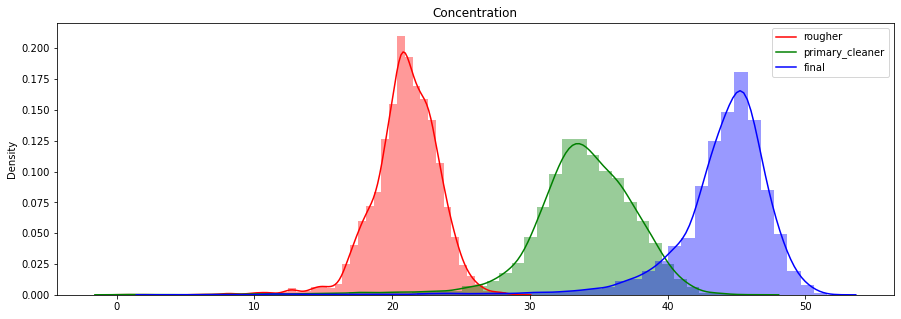

In [39]:
concentrate('rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au')

Концентрация золота высокая в сырье и финальном концентрате (около 0.200). после первой отчиски концентрация меньше, но распределена широко.

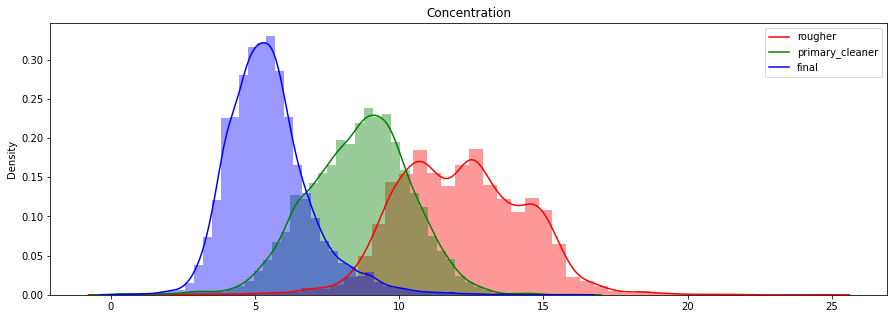

In [40]:
concentrate('rougher.output.concentrate_ag', 'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag')

Концентрация серебра самая большая в финальной концентрации. Но в общей сумме немного (около 0.30).

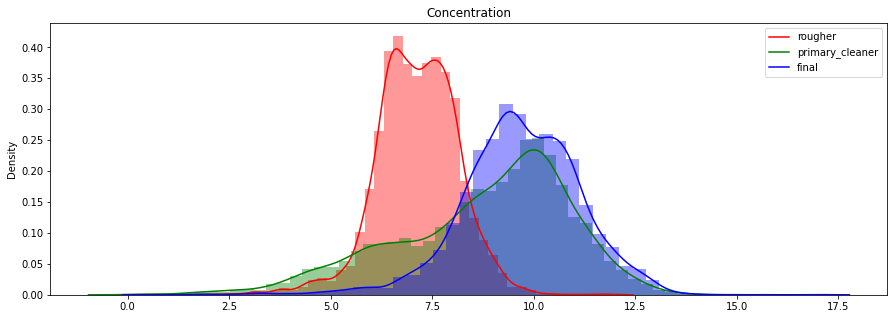

In [41]:
concentrate('rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb')

В сырье цвинца больше, но разница не критичная между концентрацией в сырье, первичной очистки и финальной (около 0.30-0.35).

## Анализ данных. 
Сравнение распределения размеров гранул сырья на обучающей и тестовой выборках

In [42]:
train_rougher_size = train[train['rougher.input.feed_size'] < 120]
test_rougher_size = test[test['rougher.input.feed_size'] < 120]

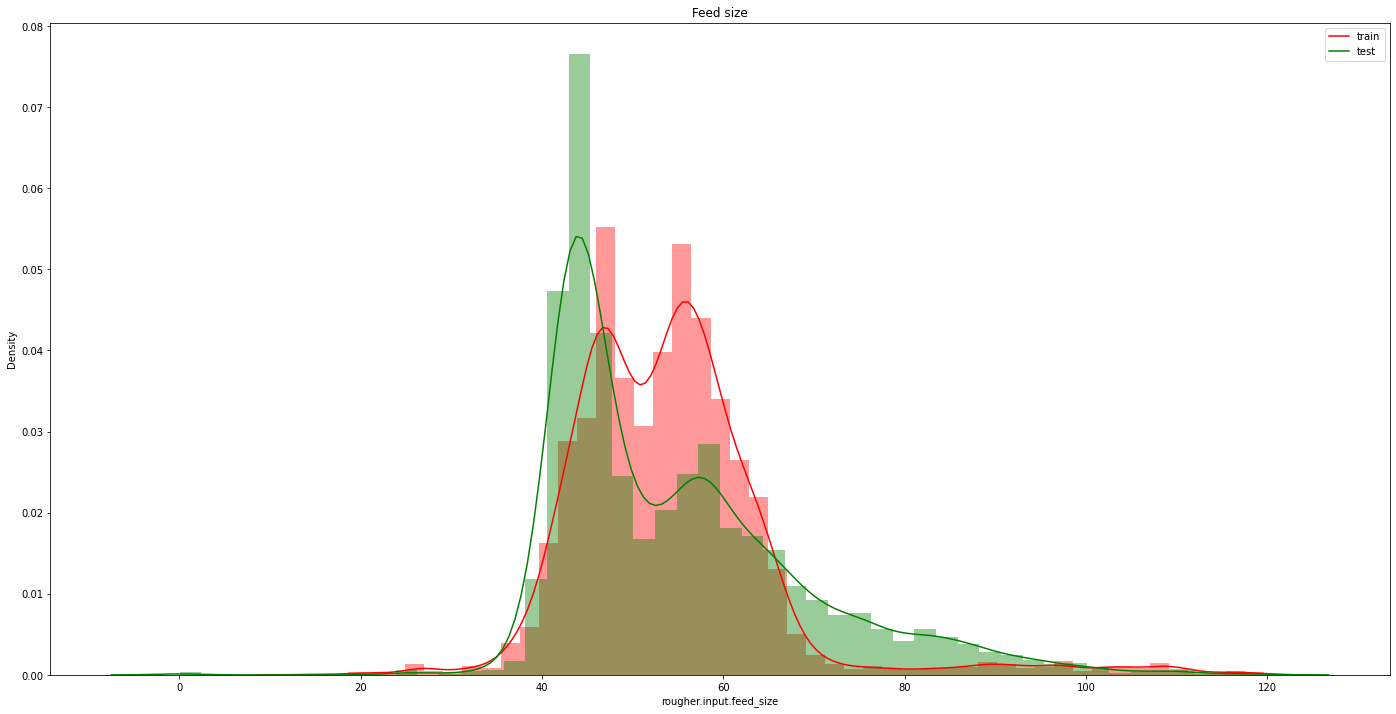

In [43]:
plt.figure(figsize=(24,12))
sns.distplot(train_rougher_size['rougher.input.feed_size'], bins=None, hist=True, color='red')
sns.distplot(test_rougher_size['rougher.input.feed_size'], bins=None, hist=True, color='green')
plt.legend(['train', 'test'])
plt.title('Feed size')
plt.show()

In [44]:
train_primary_size = train[train['primary_cleaner.input.feed_size'] < 10]
test_primary_size = test[test['primary_cleaner.input.feed_size'] < 10]
train_primary_size = train_primary_size[train_primary_size['primary_cleaner.input.feed_size'] > 4]
test_primary_size = test_primary_size[test_primary_size['primary_cleaner.input.feed_size'] > 4]

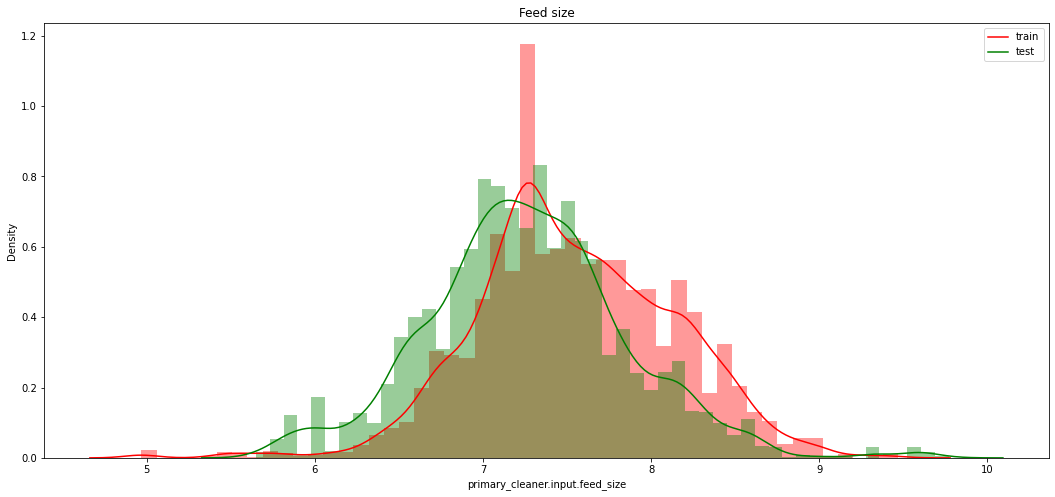

In [45]:
plt.figure(figsize=(18,8))
sns.distplot(train_primary_size['primary_cleaner.input.feed_size'], bins=None, hist=True, color='red')
sns.distplot(test_primary_size['primary_cleaner.input.feed_size'], bins=None, hist=True, color='green')
plt.legend(['train', 'test'])
plt.title('Feed size')
plt.show()

Распределения не имеют критических различий, поэтому на оценку моделей это не должно повлиять.

## Анализ данных. 
Исследование суммарной концентрации всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. 

In [46]:
def concentrate_sum (ag, pb, au, sol):
    summa = full[ag] + full[pb] + full[au] + full[sol]
    return summa

In [47]:
input_sum = concentrate_sum('rougher.input.feed_ag', 'rougher.input.feed_pb', 'rougher.input.feed_au', 'rougher.input.feed_sol')

In [48]:
rougher_sum = concentrate_sum('rougher.output.concentrate_ag', 'rougher.output.concentrate_pb', 'rougher.output.concentrate_au', 'rougher.output.concentrate_sol')

In [49]:
final_sum = concentrate_sum('final.output.concentrate_ag', 'final.output.concentrate_pb', 'final.output.concentrate_au', 'final.output.concentrate_sol')


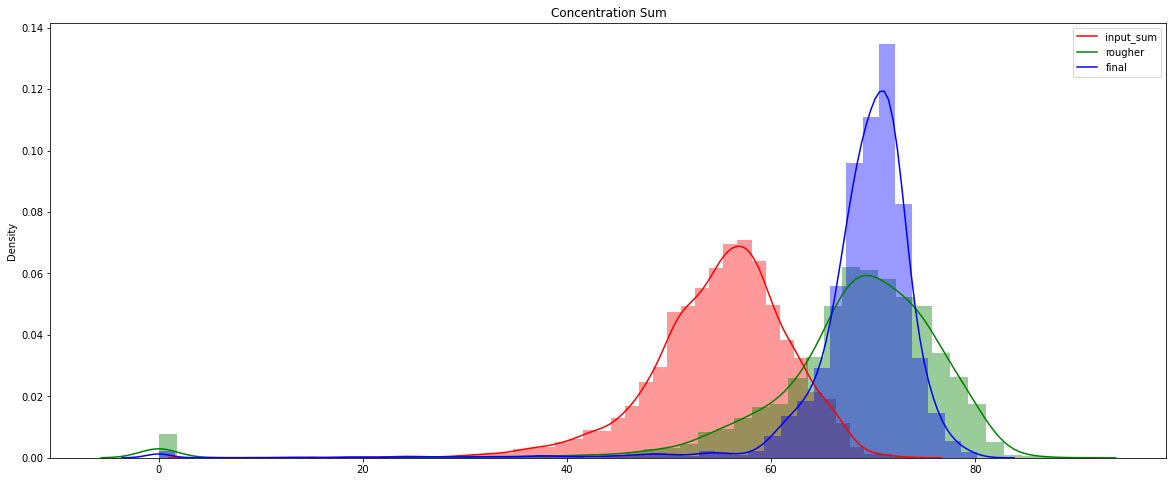

In [50]:
plt.figure(figsize=(20,8))
sns.distplot(input_sum, bins=None, hist=True, color='red')
sns.distplot(rougher_sum, bins=None, hist=True, color='green')
sns.distplot(final_sum, bins=None, hist=True, color='blue')
plt.legend(['input_sum', 'rougher', 'final'])
plt.title('Concentration Sum')
plt.show()

Удаление выбросов в train и test, которые видно в full на графике возле нуля. Из 12 столбцов в train и test есть только столбцы rougher_input_feed_



In [51]:
def outlier (df, input_sum):
    df = df.drop(input_sum[input_sum < 1].index, errors='ignore')
    return df

In [52]:
train = outlier (train, input_sum)

In [53]:
test = outlier (test, input_sum)

In [54]:
train.shape

(6506, 54)

In [55]:
test.shape

(5290, 54)

В финальной стадии концентрация самая высокая и имеет меньший разброс. Так же были небольшие аномалии у нуля. Они были удалены, что бы не оказывать в дальнейшем пагубное влияние на модели.

## Построение модели

Функция для вычисления итоговой sMAPE

Итоговое sMAPE вычисляется по формуле:

Итоговое sMAPE = 25% * sMAPE(rougher) + 75% \* sMAPE(final)

Перенесем выражнение в простую функцию как по заданию:

def smape_total (target, predictions):
  
 * result = 0.25 * smape_rougher + 0.75 * smape_final
  
 * return result
  
Далее она будет преобразована в код для выполнения конкретных задач.

Метрика sMAPE вычисляется так:

sMAPE = 1/N * Σ ( |Yi - Y'i| ) / ( |Yi| + |Y'i| ) / 2) \* 100%

Перенесем выражнение в функцию:

In [56]:
def smape (target, predictions):
    res = (1 / len(target)) * (((abs(target - predictions))/ ((abs(target) + abs(predictions)) / 2 )).sum()) * 100  
    return res

Yi - Значение целевого признака для объекта с порядковым номером i в выборке, на которой измеряется качество.

Y'i - Значение предсказания для объекта с порядковым номером i, например, в тестовой выборке

N - Количество объектов в выборке.

Σ - Суммирование по всем объектам выборки ( i меняется от 1 до N )

In [57]:
smape_scorer = make_scorer(smape, greater_is_better=False)

## Построение модели

Обучение моделей и оценка их качества с помощью кросс-валидации. Определение лучшей модели и проверка на тестовой выборке

In [58]:
features_train = train.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)
target_train = train[['rougher.output.recovery', 'final.output.recovery']]

In [59]:
display(features_train.shape)
display(target_train.shape)

(6506, 52)

(6506, 2)

In [60]:
features_test = test.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)
target_test = test[['rougher.output.recovery', 'final.output.recovery']]

In [61]:
display(features_test.shape)
display(target_test.shape)

(5290, 52)

(5290, 2)

#### Линейная регрессия

In [62]:
def model_linear (features_train, target_train, features_test, target_test):
  model = LinearRegression()
  model.fit(features_train, target_train)
  predictions_linear = model.predict(features_test)
  rmse = math.sqrt(mean_squared_error(target_test, predictions_linear))
  scores = cross_val_score(model, features_train, target_train, scoring = smape_scorer, cv = 5)
  scores = abs(scores.mean())
  print('scores:', scores)
  return predictions_linear

In [63]:
predictions_linear_rougher = model_linear (features_train, target_train['rougher.output.recovery'], features_test, target_test['rougher.output.recovery'])

scores: 9.989793258078839


In [64]:
predictions_linear_rougher = pd.Series(predictions_linear_rougher, index=target_test.index)

In [65]:
predictions_linear_final = model_linear (features_train, target_train['final.output.recovery'], features_test, target_test['final.output.recovery'])

scores: 11.257032981283489


In [66]:
predictions_linear_final = pd.Series(predictions_linear_final, index=target_test.index)

Расчет итоговой sMAPE (преобразуем функцию)

In [91]:
def smape_total (target, predictions_rougher, predictions_final):
  smape_rougher = smape(target_test['rougher.output.recovery'], predictions_rougher)
  smape_final = smape(target_test['final.output.recovery'], predictions_final)
  result = 0.25 * smape_rougher + 0.75 * smape_final
  return result

In [92]:
smape_total (target_test, predictions_linear_rougher, predictions_linear_final)

9.361241006240359

#### Случайный лес

Воспользуемся GridSearchCV для автоматического подбора параметров.

In [69]:
clf = RandomForestRegressor()
grid_parametrs = { 'n_estimators': range (10, 61, 10),
              'max_depth': [3, 4, 9, 15, 30] }
grid = GridSearchCV(clf, grid_parametrs, scoring=smape_scorer, cv=5)

In [70]:
grid.fit(features_train, target_train['rougher.output.recovery'])

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [3, 4, 9, 15, 30],
                         'n_estimators': range(10, 61, 10)},
             scoring=make_scorer(smape, greater_is_better=False))

In [71]:
grid.best_params_

{'max_depth': 3, 'n_estimators': 10}

In [72]:
grid.best_score_

-10.10090156412523

In [73]:
grid.fit(features_train, target_train['final.output.recovery'])

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [3, 4, 9, 15, 30],
                         'n_estimators': range(10, 61, 10)},
             scoring=make_scorer(smape, greater_is_better=False))

In [74]:
grid.best_params_

{'max_depth': 3, 'n_estimators': 30}

In [75]:
grid.best_score_

-10.008118044050395

Применим лучшие параметры (n_estimators попробовать 40 и 50):

In [76]:
def model_forest (features_train, target_train, features_test, target_test):  
    model = RandomForestRegressor(n_estimators=50, max_depth=4, random_state=12345)
    model.fit(features_train, target_train)
    predictions_forest = model.predict(features_test)
    scores = cross_val_score(model, features_train, target_train, scoring = smape_scorer, cv = 5)
    scores = abs(scores.mean())
    print('scores:', scores)
    return predictions_forest

In [77]:
predictions_forest_rougher = model_forest (features_train, target_train['rougher.output.recovery'], features_test, target_test['rougher.output.recovery'])

scores: 11.05474230074825


In [78]:
predictions_forest_rougher = pd.Series(predictions_forest_rougher, index=target_test.index)

In [79]:
predictions_forest_final = model_forest (features_train, target_train['final.output.recovery'], features_test, target_test['final.output.recovery'])

scores: 10.423497337719978


In [80]:
predictions_forest_final = pd.Series(predictions_forest_final, index=target_test.index)

Расчет итоговой sMAPE

In [81]:
smape_total (features_test, predictions_forest_rougher, predictions_forest_final)

6.81783908522224

 Посчитаем DummyRegressor

In [99]:
dummy_median = DummyRegressor(strategy = 'median').fit(features_train, target_train['rougher.output.recovery'])
dummy_mean = DummyRegressor(strategy = 'mean').fit(features_train, target_train['rougher.output.recovery'])
rougher_predictions_dummy_median = dummy_median.predict(features_test) 
rougher_predictions_dummy_mean = dummy_mean.predict(features_test)
rougher_score_dummy_median = smape (target_test['rougher.output.recovery'], rougher_predictions_dummy_median)
rougher_score_dummy_mean = smape (target_test['rougher.output.recovery'], rougher_predictions_dummy_mean)

In [100]:
print('Для rougher - median:', rougher_score_dummy_median)
print('Для rougher - mean:', rougher_score_dummy_mean)

Для rougher - median: 7.766862284368561
Для rougher - mean: 9.480344503979877


In [101]:
dummy_median = DummyRegressor(strategy = 'median').fit(features_train, target_train['final.output.recovery'])
dummy_mean = DummyRegressor(strategy = 'mean').fit(features_train, target_train['final.output.recovery'])
final_predictions_dummy_median = dummy_median.predict(features_test) 
final_predictions_dummy_mean = dummy_mean.predict(features_test)
final_score_dummy_median = smape (target_test['final.output.recovery'], final_predictions_dummy_median)
final_score_dummy_mean = smape (target_test['final.output.recovery'], final_predictions_dummy_mean)

In [103]:
print('Для final - median:', final_score_dummy_median)
print('Для final - mean:', final_score_dummy_mean)

Для final - median: 6.2975146035811695
Для final - mean: 7.5265731677863545


Расчитаем итоговые sMAPE для DummyRegressor (медиана и средняя):

Для медианы:

In [108]:
smape_total (target_test, rougher_predictions_dummy_median, final_predictions_dummy_median)

6.664851523778017

Для средних значений:

In [109]:
smape_total (target_test, rougher_predictions_dummy_mean, final_predictions_dummy_mean)

8.015016001834736

Из всех моделей лучший результат у констрантной модели DummyRegressor.

## Общие выводы

В данном проекте были подготовлены разные модели предсказывающие коэффициент восстановления золота из золотосодержащей руды, так же расчитана и спрогназирована эффективность обогщения чернового и финального концентратов. Подробнее:

1. Были даны три таблицы с данными , которые были названы full, train and test. Для основной работы использовались две таблицы train and test. Таблица full использовалась для анализа данных на разных стадиях процесса обработки руды и для получения недостающей информации в train and test.

2. Для начала данные были изучены, выяснили, что в train and test разное количество признаков, поэтому лишние в train были удалены. Так же в test не было целевых признаков, они были добавлены туда из full таблицы.

3. Пропуски были заполнены близлежащими значениями в столбцах методом "fill". 

4. Так же в проекте была расчитала эффективность обогащения. Посредством MAE было выявлено, что итоговый расчет практически совпадает с данными столбца "rougher.output.recovery", т.к. MAE равно ~ 9,76е-15

5. На следующем этапе проекта был проведен анализ данных по следующим направленям: анализ концентрации металлов, сравнение распределения размеров гранул сырья и исследование суммарной концентрации всех веществ в сырье, в черновом и финальном концентратах. Выводы написаны под каждым шагом анализа (здесь без дублирования). После проведенного анализа небольшая доля с выбросами была удалена из таблицы train (в test  этих данных нет).

6. В завершающем этапе проекта были построены модели предсказывающие коэффициент восстановления золота из золотосодержащей руды. Для оценки результата былА введена метрика качества "Итоговая sMAPE". Использовались две модели Линейная регрессия и Случайный лес (регрессия). Для Случайного леса использовался метод GridSearchCV с подборкой параметров для достижения наилучшего результата. Результаты "Итоговой sMAPE" были следующими: линейная регрессия = 9.36 и Случайный лес = 6.81. 

7. Для сравнения с константной моделью использовась Дамми Рергрессия: лучший результат 6.66 достигнут с методом "Медиана". На данном этапе это лучший результат и все остальные модели оказались не эффективны и время на подбор параметров было потрачено зря :) . При этом Случайный лес показал не намного хуже результаты, соответственно что бы улучшить его результат необходимо расширить  параметры в методе GridSearchCV и подобрать другие параметры , которые смогут дать самый лучший результат. Просто оставив считать на ночь  :))) .